In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display # 波形のプロットに必要
import IPython.display as ipd #jupyter-notebook上で音声再生
import glob
import re
import seaborn as sns
import pickle
import scipy.signal as ss
import os

# keras
import keras
#from keras.datasets import mnist
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical

# モデル可視化用
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


Using TensorFlow backend.


In [2]:
# ユーティリティ関数の読み込み
from Util import NormalizeHorizontalDirection
from Util import DefineModel
#from Util import SpectrogramDataGenerator

from project_utility import f1,f1_loss

# resnet構築に必要な関数、クラスを読み込み
# resnetの構築に必要なライブラリを読み込み
from resnet import compose,ResNetConv2D,ResnetBuilder,shortcut,basic_block,residual_blocks,bottleneck

%matplotlib inline

In [3]:
# jupyter-notebookのcellの幅を広げる
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:100%!important;}</style>"))

In [4]:
# 作業ディレクトリの設定
os.chdir("/home/taichi/DataAnalysis/05_NTT_corevo")

In [5]:
train_info = pd.read_csv("01_input/ntt_corevo/class_train.tsv",
                        delimiter = "\t",
                        names = ["filename","label"])

train_info["filepath"] = "03_work/spectrogram/" + train_info["filename"] + ".pickle"


In [6]:
train_info.head()

,filename,label,filepath
0,0002f1cd968ca78ada9e1c7037224773,MA_CH,03_work/spectrogram/0002f1cd968ca78ada9e1c7037...
1,0003747ec9268461d4cbb9e1b86e9663,FE_AD,03_work/spectrogram/0003747ec9268461d4cbb9e1b8...
2,0003b32f378b001f0f73bf0981da8773,MA_CH,03_work/spectrogram/0003b32f378b001f0f73bf0981...
3,0004ab975bf8b59e1b19f2b7b6d1548b,MA_CH,03_work/spectrogram/0004ab975bf8b59e1b19f2b7b6...
4,0005678b57ca265a65f8ef0cc7481277,MA_AD,03_work/spectrogram/0005678b57ca265a65f8ef0cc7...


In [7]:
# ラベルをintegerに変換するdict
label2int = {}
for i,v in enumerate(np.unique(train_info["label"])):
    label2int[v] = i

# クラスラベルのサイズ
num_classes = len(np.unique(train_info["label"]))
 

In [8]:
# 学習データの分割
# データを学習データと評価用データに分割
X_train,X_val,y_train,y_val = train_test_split(np.array(train_info["filepath"]),
                                                 np.array(train_info["label"]),
                                                            test_size=0.1,
                                                random_state = 1234)

# 学習データ内に複数の同一話者が存在するせいかlocal CVがうまく計算できないのでやめる。
# 学習データセットを分割し、モデル選択用のデータセットを作成
#X_train,X_val,y_train,y_val = train_test_split(X_train,
#                                               y_train,
#                                               test_size = 0.1,
#                                              random_state = 1234)

In [9]:
# スペクトログラム(入力データ)のサイズ
input_shape = (512,300,1)

In [10]:
# モデルを定義
###model = DefineModel(input_shape,num_classes)
model = ResnetBuilder.build_resnet_50(input_shape, num_classes)

In [11]:
#SVG(model_to_dot(model,show_shapes=True).create(prog="dot",format="svg"))

In [32]:
#LEARNING_RATE = 0.000002
#model.compile(loss = "sparse_categorical_crossentropy",
#                      optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
#                      metrics=['accuracy'])

model.compile(loss = f1_loss,
                      optimizer=SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                      metrics=[f1,'accuracy'])


In [33]:
# データのジェネレータを定義
class SpectrogramDataGenerator(object):
    def __init__(self):
        self.reset()
#        self.num_classes = num_classes

    def reset(self):
        self.spectrograms = []
        self.labels = []
        
    def zero_padding(self,spectral,thre):
        n_col = spectral.shape[1]
        if n_col >= thre :
            spectral_pad = spectral[:,0:thre]
        else:
            # lbをランダムに設定
           # lb = np.random.randint(0,thre - n_col + 1)
            lb = 0
            ub = thre - n_col - lb
            spectral_pad = np.pad(spectral,((0,0),(lb,ub)),"constant")
        return(spectral_pad)
        
    def GenerateBatch(self,X,y,speaker_dict,time_len = 300,batch_size = 10,shuffle = True,margin_ms = 0):
        num_classes = len(speaker_dict.keys())
        while True:
            if shuffle:
                indexes = np.random.permutation(len(X))
                X = X[indexes]
                y = y[indexes]

            for tmp_X,tmp_y in zip(X,y):
                with open(tmp_X,"rb") as f:
                    fr,t,spectral = pickle.load(f)
                if (spectral.shape[1] - time_len) <= 0:
                    lb_ms = 0
                    ub_ms = spectral.shape[1]#
                    #np.random.randint(margin_ms,spectral.shape[1])
                else:
                    lb_ms = np.random.randint(margin_ms,spectral.shape[1] - time_len)
                    ub_ms = lb_ms + time_len

                #周波数方向に正規化
                spectral_norm = NormalizeHorizontalDirection(spectral[:,lb_ms:ub_ms])
                # thre 以下の場合はpadding
                spectral_norm = self.zero_padding(spectral_norm,time_len)
                target = to_categorical(speaker_dict[tmp_y],num_classes=num_classes)
                
                self.spectrograms.append(spectral_norm)
                self.labels.append(target)

                if len(self.labels) == batch_size:
                    inputs = np.asarray(self.spectrograms, dtype=np.float32).reshape(batch_size,
                                                                                   spectral_norm.shape[0],
                                                                                    spectral_norm.shape[1],1)
                    targets = np.asarray(self.labels, dtype=np.float32)
                    self.reset()
                    yield (inputs,targets)


In [34]:
#for i in train_datagen.GenerateBatch(X_train,y_train,label2int,batch_size = BATCH_SIZE):
#    break

In [35]:
# ジェネレータを生成
train_datagen = SpectrogramDataGenerator()
val_datagen = SpectrogramDataGenerator()

# エポック数を設定
NUM_EPOCHS = 2000

# バッチサイズの設定
BATCH_SIZE = 10

# 1epoch当たりの学習につかうデータの量を設定
# たとえば、N_MULTIが2の時、1epoch当たり学習データを2倍に増やし、学習。
N_MULTI = 1

In [36]:
# FIXME patience15は多すぎるかもしれない。8くらいで良いかも
patience = 0
es = EarlyStopping(monitor = "val_loss",
                   patience = patience)

mc = ModelCheckpoint("03_work/models/resnet/resnet_model.h5",
                    monitor = "val_loss",
                    save_best_only = True,
                    verbose = 1)

# FIXME : momentumなどを用いて、最適化時間を短縮する。
hist = model.fit_generator(generator = train_datagen.GenerateBatch(X_train,y_train,label2int,batch_size = BATCH_SIZE),
                           epochs = NUM_EPOCHS,
                           steps_per_epoch = int(np.ceil(len(X_train) * N_MULTI/ BATCH_SIZE)),
                           validation_data = val_datagen.GenerateBatch(X_val,y_val,label2int,batch_size = BATCH_SIZE),
                           validation_steps = int(np.ceil(len(X_val) * N_MULTI/ BATCH_SIZE)),
                           callbacks = [mc,es],
                           verbose = 1
                          )

Epoch 1/2000
 446/3403 [==>...........................] - ETA: 26:49 - loss: 5.7715 - f1: 0.3089 - acc: 0.4323

KeyboardInterrupt: 

In [18]:
# label2intを保存する
with open("03_work/label2int.pickle","wb") as f:
    pickle.dump(label2int,f)

In [14]:
# 学習ログの保存
for key in hist.history.keys():
    np.savetxt("03_work/models/resnet/logs/{0}.txt".format(key),
               hist.history[key],
               delimiter=",")

NameError: name 'hist' is not defined

In [15]:
# 訓練履歴の可視化
## 履歴の読み込み
savedir = "03_work/models/resnet/"
train_loss = np.loadtxt("03_work/models/resnet/logs/loss.txt")
train_acc = np.loadtxt("03_work/models/resnet/logs/acc.txt")

val_loss = np.loadtxt("03_work/models/resnet/logs/val_loss.txt")
val_acc = np.loadtxt("03_work/models/resnet/logs/val_acc.txt")

## 訓練誤差の履歴をプロット
plt.figure()
plt.title("Loss")
plt.plot(range(len(train_loss)),train_loss,label = "train_loss")
plt.plot(range(len(val_loss)),val_loss,label = "val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

OSError: 03_work/models/logs/loss.txt not found.

NameError: name 'train_acc' is not defined

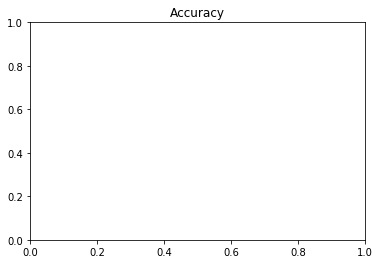

In [16]:
## 正解率の履歴をプロット
plt.figure()
plt.title("Accuracy")
plt.plot(range(len(train_acc)),train_acc,label = "train_acc")
plt.plot(range(len(val_acc)),val_acc,label = "val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

In [19]:
# validationデータに対するLossが最も小さかったベストモデルの読み込み
model = load_model("03_work/models/cnn_model_01.h5")

In [20]:
# ジェネレータを生成
test_datagen = SpectrogramDataGenerator()

# バッチサイズの設定
BATCH_SIZE = 10

# 1epoch当たりの学習につかうデータの量を設定
N_MULTI = 1

evaluation = model.evaluate_generator(generator = test_datagen.GenerateBatch(X_test,y_test,label2int,batch_size = BATCH_SIZE),
                                     steps = int(np.ceil(len(X_test) * N_MULTI/ BATCH_SIZE)))

In [21]:
# TODO : macro F1も計算する
# TODO : label2intを保存する
# 予測正解率を出力
print("test_loss:%.3f" % evaluation[0])
print("test_accuracy:%.3f" % evaluation[1])
#print("test_macrof1:%3f" %)

test_loss:0.117
test_accuracy:0.962


In [22]:
# TODO : 
BATCH_SIZE = 1
y_pred = model.predict_generator(generator = 
                              test_datagen.GenerateBatch(X_test,y_test,label2int,
                                                         batch_size= BATCH_SIZE,
                                                         shuffle = False),
                                 steps=int(np.ceil(len(X_test) * N_MULTI/BATCH_SIZE)))

KeyboardInterrupt: 

In [ ]:
label2int

In [ ]:
y_pred.shape

In [ ]:
# np.argmaxで予測ラベルを作成
y_pred_label_int = np.argmax(y_pred,axis = 1)
y_test_label_int = [label2int[l] for l in y_test]

In [ ]:
from sklearn.metrics import f1_score
macrof1 = f1_score(y_test_label_int, y_pred_label_int, average='macro')
print("test_macro-f1:%.3f" % macrof1)